# Импорт библиотек и загрузка данных

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

In [2]:
data = pd.read_csv('telecom_churn.csv')

# Подготовка даных

In [3]:
data = data.drop('State', axis = 1)

In [4]:
data.query('Churn == False').sample(500)

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
494,18,408,No,No,0,273.6,93,46.51,114.6,116,9.74,250.6,120,11.28,8.2,4,2.21,1,False
2516,127,510,No,Yes,19,129.7,115,22.05,160.8,101,13.67,265.0,63,11.93,12.2,3,3.29,2,False
1281,109,408,No,No,0,162.6,138,27.64,154.0,109,13.09,209.7,118,9.44,11.5,4,3.11,0,False
1479,66,415,No,Yes,16,174.7,92,29.70,232.1,105,19.73,305.4,98,13.74,8.9,2,2.40,1,False
757,112,415,No,No,0,115.8,108,19.69,243.3,111,20.68,184.6,78,8.31,13.1,5,3.54,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,160,415,No,No,0,85.8,77,14.59,165.3,110,14.05,178.5,92,8.03,9.2,4,2.48,3,False
2872,124,415,No,No,0,151.0,98,25.67,120.6,119,10.25,152.8,81,6.88,9.2,2,2.48,2,False
3254,57,415,No,Yes,30,179.2,105,30.46,283.2,83,24.07,228.1,77,10.26,14.7,5,3.97,1,False
1611,83,415,No,Yes,20,95.0,89,16.15,167.9,92,14.27,200.6,79,9.03,11.2,2,3.02,0,False


In [5]:
data.Churn.value_counts()

False    2850
True      483
Name: Churn, dtype: int64

Так как в выборке сильный дисбаланс, то лучше сразу составить ее с примерно равным распределением целевого признака, так как логистичесакая регрессия не очень справляется с несбалансированными выборками, даже если сильно заморачиваться с настройками. 

In [6]:
data_1 = data.query('Churn == False').sample(500)
data_2 = data.query('Churn == True')
data = pd.concat([data_1, data_2])

In [7]:
#Заменим основные категориальные признаки числами
data['International plan'] = data['International plan'].map({'Yes': 1,
                                                             'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1,
                                                             'No': 0})

In [8]:
data = data.drop('Area code', axis =1).join(pd.get_dummies(data['Area code']))

## Проверим данные на выбросы

In [9]:

columns  =  ['Account length',
             'International plan',
             'Voice mail plan',
             'Total day minutes',
             'Total eve minutes',
             'Total night minutes', 'Customer service calls']

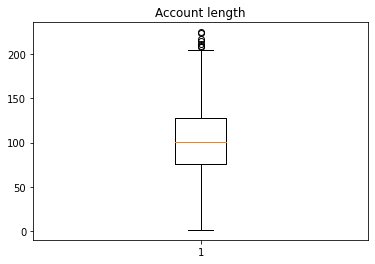

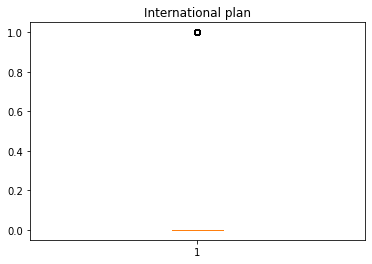

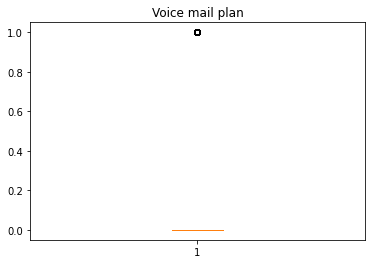

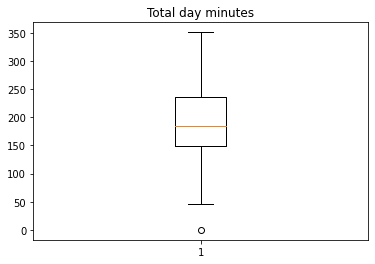

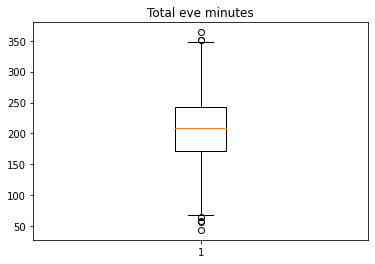

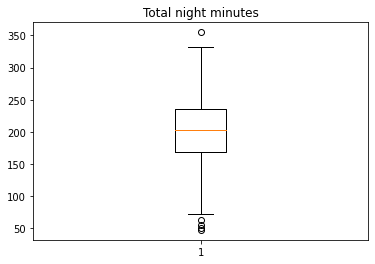

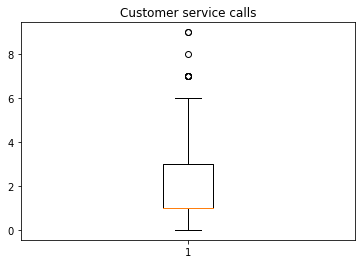

In [10]:
for f in columns:
    fig1, ax1 = plt.subplots()
    ax1.set_title(f'{f}')
    ax1.boxplot(data[f])


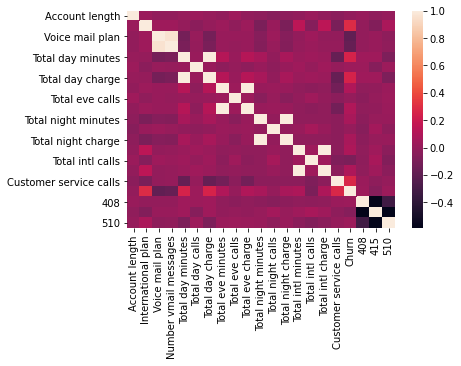

In [11]:
sns.heatmap(data.corr());

В целом выбросы особо не мешают, с корреляцией тоже сюрпризы отсутсвуют - решается с помощью параметров регуляризации. 

# Подготовка выборок

In [12]:
X = data.drop('Churn', axis = 1)
Y = data['Churn']

In [13]:
X.shape, Y.shape

((983, 20), (983,))

# Логистическая регрессия без подбора параметров

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                      test_size=0.2, 
                                                      random_state=42)

In [15]:
model = LogisticRegression()
# обучите модель
model.fit(X_train, y_train)

/Library/Python/3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [16]:
# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [17]:
f1_score(y_test, predictions)

0.7120418848167539

Очень грустно. 

In [18]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

In [19]:
X_test_st = scaler.transform(X_test)

In [20]:
model = LogisticRegression()
# обучите модель
model.fit(X_train_st, y_train)

LogisticRegression()

In [21]:
# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

In [22]:
f1_score(y_test, predictions)

0.7301587301587302

После стандартизации не так грустно, но все еще паршиво. 

# Подбор оптимальных параметров для модели

In [23]:
c_values = list(np.arange(0.1, 15, 0.2))
param_grid = [
    {'C': c_values, 
     'penalty': ['l2'], 
     'solver' : ['liblinear'], 
     'multi_class' : ['ovr'],
    'class_weight':['balanced']}]
     

In [24]:
np.arange(0.1, 10, 0.2)

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9, 5.1,
       5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7,
       7.9, 8.1, 8.3, 8.5, 8.7, 8.9, 9.1, 9.3, 9.5, 9.7, 9.9])

In [25]:
model = LogisticRegression()

In [26]:
grid = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1')
grid.fit(X_train_st, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 0.30000000000000004, 0.5000000000000001,
                                0.7000000000000001, 0.9000000000000001,
                                1.1000000000000003, 1.3000000000000003,
                                1.5000000000000004, 1.7000000000000004,
                                1.9000000000000004, 2.1000000000000005,
                                2.3000000000000007, 2.5000000000000004,
                                2.7000000000000006, 2.900000000000001,
                                3.1000000000000005, 3.3000000000000007,
                                3.500000000000001, 3.7000000000000006,
                                3.900000000000001, 4.1000000000000005,
                                4.300000000000001, 4.500000000000001, 4.7, 4.9,
                                5.1000000000000005, 5.300000000000001,
                                5.500000000000001, 5.700000000000001, 5.9, 

In [27]:
grid.best_score_

0.7615520142248744

In [28]:
grid.best_params_

{'C': 0.7000000000000001,
 'class_weight': 'balanced',
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}

По сути своей это угадывание, так как если всегда говорить, что клиент не уйдет от нас - результат практически аналогичный. 


## Оптимизацию можно начать с трешхолда

In [29]:
model = LogisticRegression(C= 9, class_weight=  'balanced', penalty = 'l2')

In [30]:
# обучите модель
model.fit(X_train_st, y_train)

LogisticRegression(C=9, class_weight='balanced')

In [31]:
# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

In [32]:
threshold = 0.54

In [33]:
custom_predictions = [0 if i<threshold else 1 for i in probabilities]

In [34]:
f1_score(y_test, custom_predictions)

0.72

После балансировки выборки, модель показала приемлимые результаты. 

# Случайный лес

In [35]:
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 42)
gb_model.fit(X_train, y_train)# обучим модель случайного леса


GradientBoostingClassifier(random_state=42)

In [36]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
gb_predictions = gb_model.predict(X_test)
gb_probabilities = gb_model.predict_proba(X_test)[:,1]


In [37]:
f1_score(y_test, gb_predictions)

0.8947368421052632

Логично, что в градиентный бустинг сильно лучше показал результаты.
Если бы задача была живая и рабочая, то логистической 